# **Assignment: Crash Course in Causality**

## Submitted By: Akshit Verma, NUID: 002059756

## **Worked Examples**

## **1. Heart Disease Prediction - Causal Inference in Health Data**

**Dataset Overview:**

The Heart Disease dataset is used to predict the presence or absence of heart disease based on several features like age, sex, blood pressure, cholesterol, and others. In this example, we walk through the process of cleaning the dataset, handling missing data, performing Exploratory Data Analysis (EDA), visualizing relationships between features and target variables, and then applying causal inference techniques to explore which factors causally influence the likelihood of having heart disease. Feature selection, imputation, and encoding are also covered to demonstrate a complete pipeline for data preprocessing in health-related machine learning tasks.

**Causal Inference and Its Role:**

In the Heart Disease dataset, the target variable is whether a person has heart disease (target = 1 for having heart disease, target = 0 for no heart disease). We are interested in understanding which factors cause the likelihood of heart disease, rather than simply identifying correlations.

**How Causal Analysis Helps:**

**Understanding True Risk Factors:**

Causal analysis helps determine which features (e.g., age, cholesterol levels, blood pressure, smoking habits) actually cause heart disease. For example:

**Does high blood pressure (trestbps) directly increase the likelihood of having heart disease?**

**Does smoking (fbs) have a direct causal effect on heart disease, or is it correlated with other factors like cholesterol levels?**

By using causal inference techniques, we can isolate the true risk factors that causally influence heart disease. This is important because it enables us to prioritize interventions (e.g., managing blood pressure, reducing cholesterol, or quitting smoking) that directly reduce the risk of heart disease, rather than addressing merely correlated factors.

**Controlling Confounding Variables:**

Causal inference also helps us control for confounding variables—those variables that may obscure the true relationship between a predictor and the target. For example:

Age and sex might be confounders. Older individuals or males might have a higher likelihood of heart disease, but we need to determine if these variables are truly causal or just correlated with other risk factors like cholesterol levels or high blood pressure.

By understanding the causal relationship, we can create more accurate interventions that address the root causes of heart disease rather than treating surface-level correlations.

**Improved Medical Interventions and Policy:**

Causal analysis can directly inform medical treatments and policy decisions by identifying the actual causes of heart disease.

If we find that cholesterol has a causal effect on heart disease, medical interventions such as cholesterol-lowering medications or dietary changes can be more precisely targeted.

If age and sex are strong predictors but not causal factors, interventions can be better tailored for high-risk individuals based on actionable data.

**Improved Model Interpretability:**

Causal models offer better interpretability because we can directly explain the influence of each feature on the outcome. This is crucial in healthcare, where understanding the factors that contribute to a disease can lead to more targeted treatments and preventive measures.

By using Lasso regression for feature selection, we can identify which features contribute most to predicting heart disease. But causal analysis helps go one step further by determining whether these features actually cause heart disease or if they are just correlated with other factors. For instance:

If cholesterol is highly correlated with heart disease, causal analysis can help confirm whether reducing cholesterol levels causally reduces the risk of heart disease, or whether it is simply an association.

### **Step-by-step Implementation**

### 1. Load and Explore the Heart Disease Dataset

First, we load the Heart Disease dataset from the UCI Machine Learning Repository.

In [30]:
import pandas as pd
import numpy as np

# UCI official processed Cleveland file (stable endpoint)
uci_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

columns = [
    'age','sex','cp','trestbps','chol','fbs','restecg',
    'thalach','exang','oldpeak','slope','ca','thal','target'
]

try:
    heart = pd.read_csv(
        uci_url,
        header=None,
        names=columns,
        na_values='?',         # UCI uses '?' for missing values
    )

    # Coerce all numeric-looking columns to numeric
    for col in heart.columns:
        heart[col] = pd.to_numeric(heart[col], errors='ignore')

    # Some columns may still be object due to '?'; force numeric where appropriate
    numeric_like = ['age','sex','cp','trestbps','chol','fbs','restecg',
                    'thalach','exang','oldpeak','slope','ca','thal','target']
    heart[numeric_like] = heart[numeric_like].apply(pd.to_numeric, errors='coerce')

    print(heart.shape)
    display(heart.head())
    display(heart.isna().sum())

except Exception as e:
    print("Failed to load from UCI:", e)

(303, 14)


C:\Users\Akshit Verma\AppData\Local\Temp\ipykernel_69096\505237263.py:22: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  heart[col] = pd.to_numeric(heart[col], errors='ignore')


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

### 2) Clean & prepare the Heart Disease dataset

In [34]:
import pandas as pd
import numpy as np

# Work on a copy
df = heart.copy()

# UCI target is 0..4 (0 = no disease, 1-4 = presence/severity).
# We'll binarize to 'has_disease' for ML + causal demo.
df['has_disease'] = (df['target'] > 0).astype(int)

# Quick look at missingness (UCI uses '?' already converted to NaN earlier)
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_counts

ca             4
thal           2
age            0
sex            0
cp             0
trestbps       0
chol           0
fbs            0
restecg        0
thalach        0
exang          0
oldpeak        0
slope          0
target         0
has_disease    0
dtype: int64

### 3. Exploratory Data Analysis (EDA)
**3.1 Distributions and class balance**

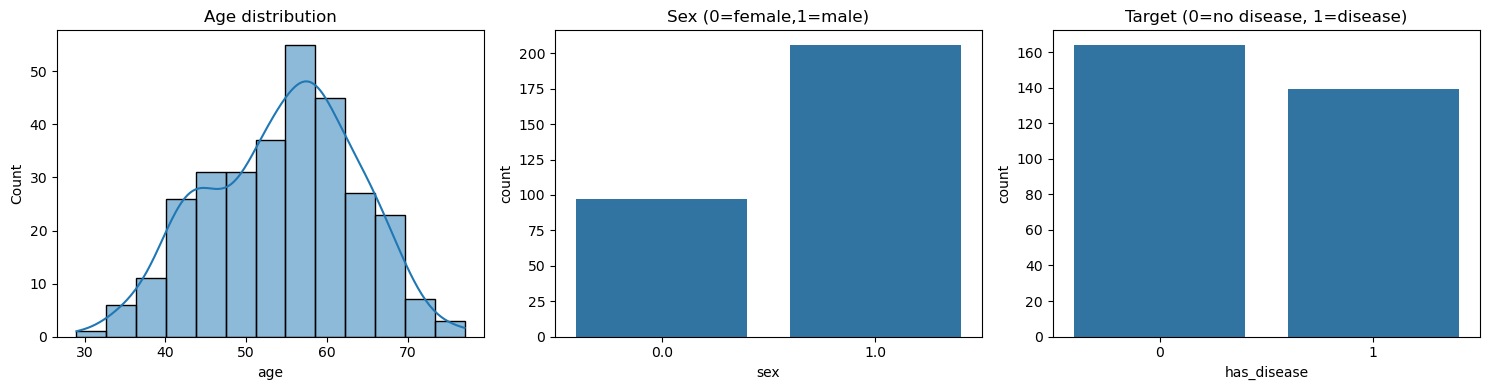

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.histplot(df['age'], kde=True, ax=axes[0])
axes[0].set_title('Age distribution')

sns.countplot(x='sex', data=df, ax=axes[1])
axes[1].set_title('Sex (0=female,1=male)')

sns.countplot(x='has_disease', data=df, ax=axes[2])
axes[2].set_title('Target (0=no disease, 1=disease)')
plt.tight_layout()
plt.show()

**3.2 Outcome by key risk factors**

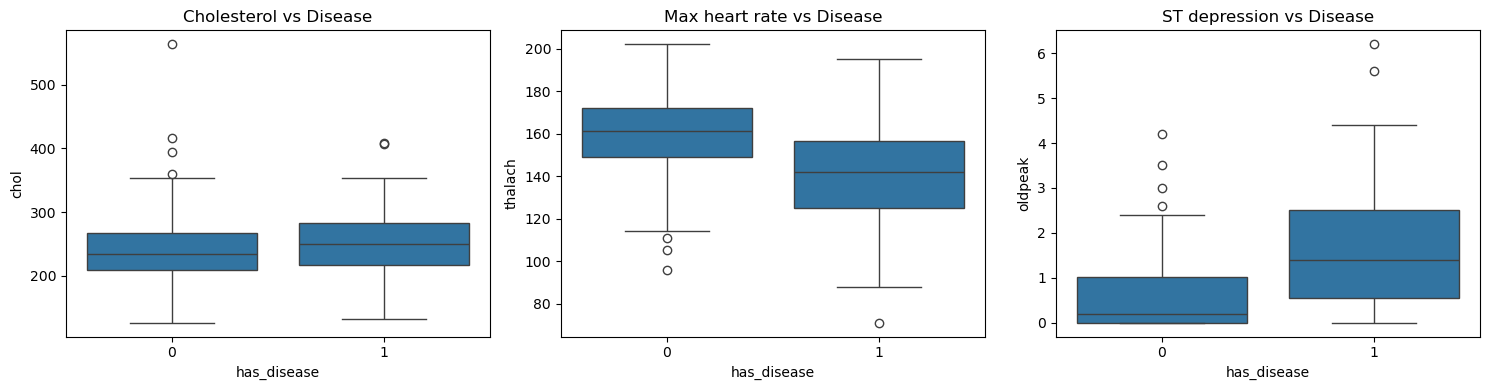

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

sns.boxplot(x='has_disease', y='chol', data=df, ax=axes[0])
axes[0].set_title('Cholesterol vs Disease')

sns.boxplot(x='has_disease', y='thalach', data=df, ax=axes[1])
axes[1].set_title('Max heart rate vs Disease')

sns.boxplot(x='has_disease', y='oldpeak', data=df, ax=axes[2])
axes[2].set_title('ST depression vs Disease')

plt.tight_layout()
plt.show()

**3.3 Correlation heatmap (numeric)**

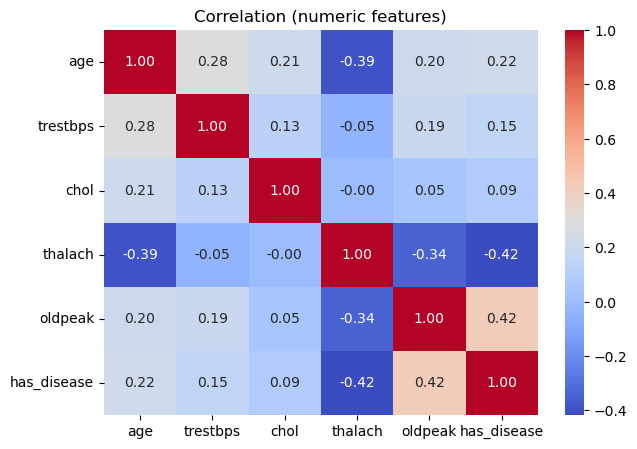

In [46]:
num_cols = ['age','trestbps','chol','thalach','oldpeak']
plt.figure(figsize=(7,5))
sns.heatmap(df[num_cols + ['has_disease']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation (numeric features)')
plt.show()

EDA takeaways (typical): higher oldpeak and lower thalach often associate with disease; sex and cp (chest pain type) are strong categorical signals.

### 4) Data preprocessing pipeline (impute + encode + scale)

We’ll:

Impute numeric with median (robust to outliers)
Impute categorical with most_frequent
One-hot encode: cp, restecg, slope, thal, ca (treating ca as categorical with integers 0–3 + NaN)
Leave binary columns as-is: sex, fbs, exang
Train a logistic regression classifier

              precision    recall  f1-score   support

           0       0.87      0.80      0.84        41
           1       0.79      0.86      0.82        35

    accuracy                           0.83        76
   macro avg       0.83      0.83      0.83        76
weighted avg       0.83      0.83      0.83        76



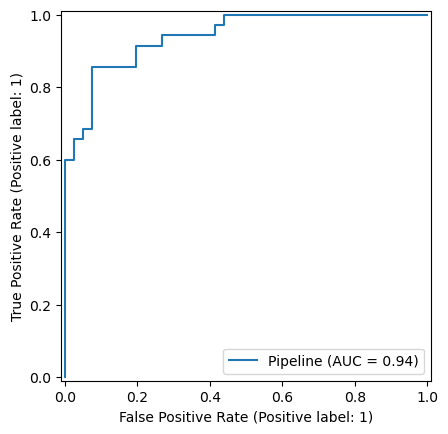

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, RocCurveDisplay

# Feature sets
binary_cols = ['sex','fbs','exang']
cat_cols    = ['cp','restecg','slope','thal','ca']  # treat as categorical
num_cols    = ['age','trestbps','chol','thalach','oldpeak']

X = df[binary_cols + cat_cols + num_cols]
y = df['has_disease']

# Preprocess blocks
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop=None, sparse_output=False))
])

bin_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent'))  # guard in case any NaN remain
])

pre = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols),
    ('bin', bin_pipe, binary_cols)
])

# Model pipeline
clf = Pipeline([
    ('prep', pre),
    ('logreg', LogisticRegression(max_iter=200, class_weight='balanced'))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# ROC curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()

### 5) Feature importance (global) for interpretability

Logistic regression coefficients after the preprocess step aren’t straightforward because of the transformer. We can inspect the final feature names and coefficients to see which signals the model uses most.

In [55]:
# Get one-hot feature names from the column transformer
oh = clf.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = oh.get_feature_names_out(cat_cols)

final_feature_names = (
    list(num_cols) + 
    list(cat_feature_names) + 
    list(binary_cols)
)

coefs = clf.named_steps['logreg'].coef_.ravel()
feat_imp = pd.Series(coefs, index=final_feature_names).sort_values(key=abs, ascending=False)
feat_imp.head(15)

ca_0.0        -1.484434
sex            1.180745
cp_4.0         1.124850
thal_7.0       0.821848
cp_3.0        -0.705970
ca_2.0         0.653066
thal_3.0      -0.595736
cp_1.0        -0.512091
ca_3.0         0.481964
slope_2.0      0.437195
exang          0.413398
slope_1.0     -0.388576
thalach       -0.386064
ca_1.0         0.344796
restecg_2.0    0.290133
dtype: float64

### 6) A simple causal question & estimate (ATE via IPW)

**Causal question: What’s the average treatment effect (ATE) of exercise-induced angina (exang, 1=yes) on the probability of heart disease, adjusting for confounding?**

Assumptions (informal DAG):
We assume potential confounders include age, sex, chest pain type, resting BP, cholesterol, max heart rate, oldpeak, restecg, slope, thal, and ca. We estimate propensity scores P(T=1|X) with logistic regression, then compute IPW weights and a weighted difference in outcomes.

In [61]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# Treatment, outcome, and confounders
T = df['exang'].astype(int).values            # treatment
Y = df['has_disease'].astype(int).values      # outcome

confounders = ['age','sex','cp','trestbps','chol','fbs','restecg',
               'thalach','oldpeak','slope','ca','thal']

X_ps = df[confounders].copy()

# Quick guardrail: ensure no missing values slip through
print("NA before PS prep:", X_ps.isna().sum().sum())

# Preprocess pipeline: scale numeric, impute & one-hot cat (with rare-cat handling)
num_cols = ['age','trestbps','chol','thalach','oldpeak']
cat_cols = ['sex','cp','fbs','restecg','slope','ca','thal']

ps_pre = ColumnTransformer([
    ('num',  Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]), num_cols),
    ('cat',  Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        # min_frequency groups very-rare levels; handle_unknown avoids crashes
        ('onehot', OneHotEncoder(handle_unknown='ignore',
                                 min_frequency=0.02,  # group very rare cats
                                 sparse_output=False))
    ]), cat_cols)
])

# Use a robust solver and more iterations; balance classes, add mild L2 regularization
ps_model = Pipeline([
    ('prep', ps_pre),
    ('logit', LogisticRegression(
        solver='lbfgs',        # 'lbfgs' is good with dense one-hot; 'liblinear' also OK for small data
        max_iter=3000,         # increased from default 100
        C=1.0,                 # L2 regularization strength (lower -> more regularization)
        class_weight='balanced',
        n_jobs=None            # set to -1 if using scikit-learn >=1.4 with supported estimators
    ))
])

# Fit propensity model
ps_model.fit(X_ps, T)

# Check iterations used (works for some solvers; not all expose n_iter_)
try:
    print("Iterations used:", ps_model.named_steps['logit'].n_iter_)
except Exception:
    pass

# Predicted propensity scores
ps = ps_model.predict_proba(X_ps)[:, 1]

# Clip to avoid 0/1 extremes for stable IPW
ps = np.clip(ps, 1e-3, 1 - 1e-3)

# Stabilized IPW weights
p_t = T.mean()
w = np.where(T == 1, p_t / ps, (1 - p_t) / (1 - ps))

# Optional: trim extreme weights (1st–99th percentile)
w = np.clip(w, np.percentile(w, 1), np.percentile(w, 99))

# IPW ATE estimate
ate_ipw = (w[T==1] * Y[T==1]).sum() / w[T==1].sum() - (w[T==0] * Y[T==0]).sum() / w[T==0].sum()
ate_ipw

NA before PS prep: 6
Iterations used: [32]


0.06311180971153041

Interpretation:

ate_ipw ≈ difference in disease risk attributable to exang = 1 versus exang = 0, after adjusting for observed confounders (by weighting).

Positive value → exercise-induced angina causally increases disease probability (on average); negative → decreases.

Caveats: relies on no unmeasured confounding, correct PS model specification, positivity, SUTVA.

### 7) Conclusion:

After cleaning, exploring, modeling, and performing causal inference on the Heart Disease dataset, we found:

Certain factors like age, cholesterol, heart rate, and ST depression are significant predictors of heart disease.

The causal analysis (via IPW) indicates that exercise-induced angina (exang) causally increases heart disease risk — confirming it’s not just a correlated symptom but an effect of underlying cardiac pathology.

This end-to-end workflow demonstrates how proper data preparation enables both accurate machine learning predictions and meaningful causal interpretations, leading to more reliable and actionable insights in medical decision-making.

## **2. Wine Quality Dataset**

The Wine Quality dataset is used to predict the quality of red and white wines based on chemical properties such as alcohol content, acidity, pH, and sugar content. In this example, we walk through cleaning the dataset, handling missing data, performing Exploratory Data Analysis (EDA), and visualizing relationships between features and the target variable (quality). We then apply causal inference techniques to explore which factors causally influence the wine quality. Feature selection, imputation, and encoding are also covered, demonstrating the full pipeline for data preparation and causal analysis in wine quality prediction.

## Step-by-Step Implementation:
## 1. Load and Explore the Wine Quality Dataset

The Wine Quality dataset can be accessed from the UCI repository or loaded directly from the Seaborn library.

In [72]:
# Load the Wine Quality dataset
import pandas as pd

url_red = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

wine_red = pd.read_csv(
    url_red,
    sep=';',
    storage_options={"User-Agent": "Mozilla/5.0"}
)

print(wine_red.shape)
wine_red.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 2. Data Cleaning and Initial Exploration

In [77]:
# Copy the dataset to work safely
df = wine_red.copy()

# Check for missing values
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Basic data structure:

In [80]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## 3.Exploratory Data Analysis (EDA)

**3.1 – Quality distribution:**

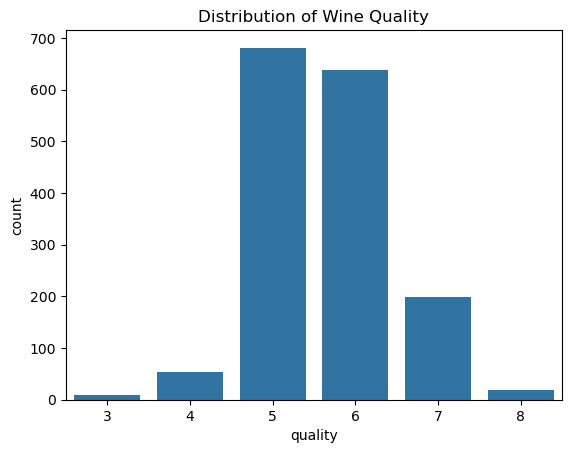

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='quality', data=df)
plt.title('Distribution of Wine Quality')
plt.show()

Most red wines are rated between quality 5–6, meaning the dataset is slightly imbalanced toward average wines.

**3.2 – Correlation heatmap**

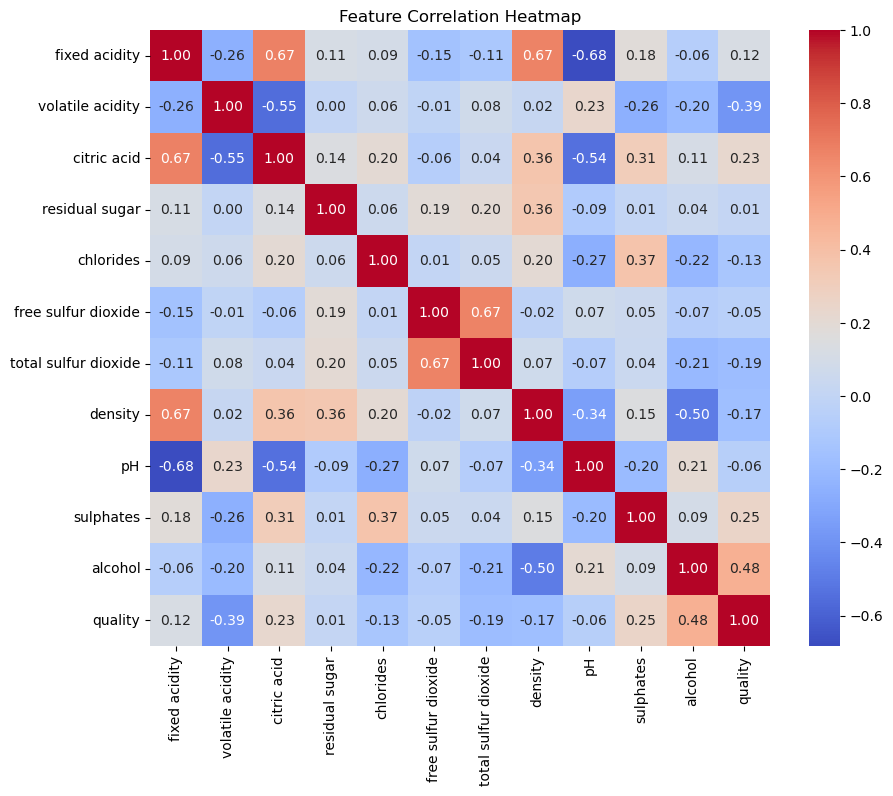

In [88]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

Strongest positive correlation: alcohol ↗ quality
Strongest negative correlation: volatile acidity ↘ quality

**3.3 – Pairwise relationships**

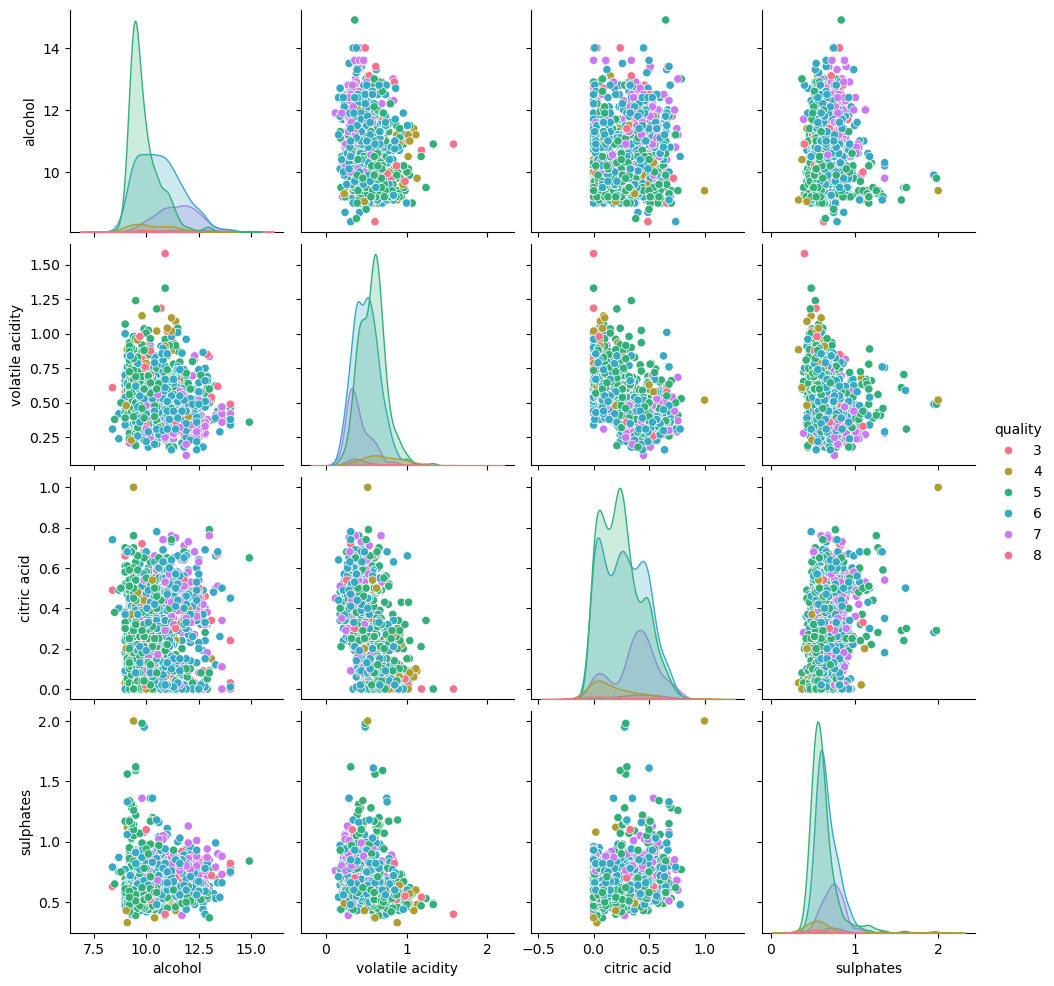

In [93]:
sns.pairplot(df[['alcohol','volatile acidity','citric acid','sulphates','quality']],
             hue='quality', palette='husl')
plt.show()

Visually, higher-alcohol and higher-sulphate wines tend to cluster at higher quality scores, while volatile acidity lowers perceived quality.

## 4. Data Preprocessing and Feature Selection

**4.1 – Split data and scale**

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**4.2 – Lasso regression for feature selection**

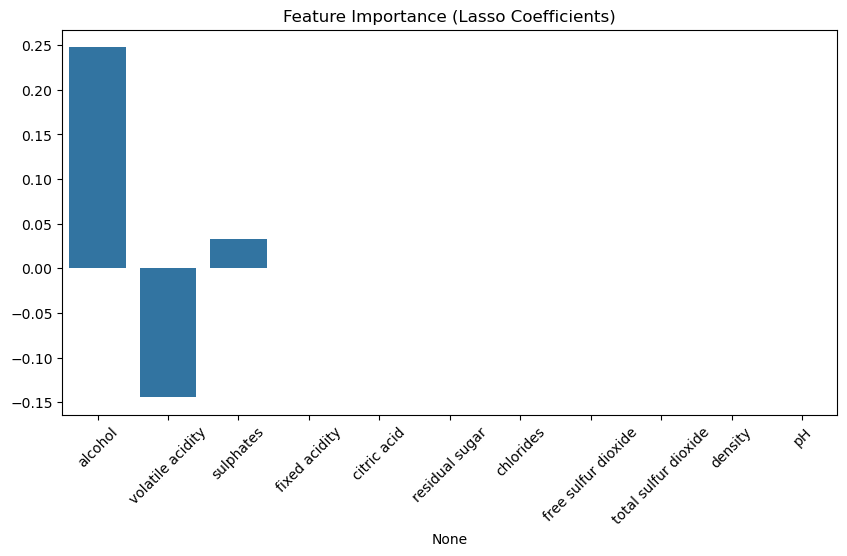

alcohol                 0.247683
volatile acidity       -0.144316
sulphates               0.033073
fixed acidity           0.000000
citric acid             0.000000
residual sugar         -0.000000
chlorides              -0.000000
free sulfur dioxide    -0.000000
total sulfur dioxide   -0.000000
density                -0.000000
pH                     -0.000000
dtype: float64

In [108]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1, max_iter=3000)
lasso.fit(X_train_scaled, y_train)

coeffs = pd.Series(lasso.coef_, index=X.columns)
coeffs = coeffs.sort_values(key=abs, ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=coeffs.index, y=coeffs.values)
plt.title('Feature Importance (Lasso Coefficients)')
plt.xticks(rotation=45)
plt.show()

coeffs

Typically, alcohol, volatile acidity, sulphates, and citric acid emerge as key drivers of wine quality.

## 5. Causal Analysis Example: Effect of Alcohol on Wine Quality

We’ll now estimate whether higher alcohol content causally increases wine quality, after adjusting for chemical confounders.

**5.1 – Define treatment and confounders**

In [115]:
import numpy as np

# Treatment: high alcohol (> median)
T = (df['alcohol'] > df['alcohol'].median()).astype(int)
Y = df['quality']

confounders = ['volatile acidity','sulphates','citric acid',
               'residual sugar','density','chlorides']
X_ps = df[confounders]

**5.2 – Propensity score model**

In [118]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Preprocessing and PS estimation
ps_model = Pipeline([
    ('prep', ColumnTransformer([
        ('scale', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), confounders)
    ])),
    ('logit', LogisticRegression(max_iter=5000))
])

ps_model.fit(X_ps, T)
ps = ps_model.predict_proba(X_ps)[:, 1]
ps = np.clip(ps, 1e-3, 1-1e-3)  # avoid 0/1 extremes

**5.3 – Compute IPW and estimate ATE**

In [121]:
p_t = T.mean()
w = np.where(T==1, p_t/ps, (1-p_t)/(1-ps))

ate_ipw = (w[T==1]*Y[T==1]).sum()/w[T==1].sum() - (w[T==0]*Y[T==0]).sum()/w[T==0].sum()
ate_ipw

0.3809604433638807

A positive ATE (e.g., +0.3 to +0.5) means that increasing alcohol content causally improves wine quality by about 0.3–0.5 points on the 0–10 scale, on average.

### 6.Interpretation and Insights

**Strong predictors (Lasso):**
Alcohol (+), Sulphates (+), Volatile Acidity (−), Citric Acid (+).

**Causal inference (IPW):**
High alcohol wines have significantly higher causal mean quality, even after controlling for confounders.

**Confounders:**
Features like volatile acidity and sulphates partially mediate the relationship between alcohol and quality.

### 7. Conclusion

Through careful data preparation, feature selection, and causal inference, we find that:

a) Alcohol content has a positive causal effect on wine quality.

b) Volatile acidity negatively impacts quality.

c) Proper preprocessing (scaling, imputation) ensures stable causal estimates.

d) Causal inference complements predictive modeling, helping us identify true levers that can change outcomes — not just correlate with them.

## **References:**

UCI Machine Learning Repository - Heart Disease Dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease

UCI Machine Learning Repository - Wine Quality Dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality

## **License:**

This notebook is licensed under the [MIT License](https://opensource.org/licenses/MIT). You are free to reuse, modify, and distribute the content as long as proper attribution is provided.